In [1]:
import os
import torch.nn as nn
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.transforms as transforms
import torchvision

from models import *

---

In [3]:
batch_size=100
transform_test = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                     torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
trainset = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=True, download=True, transform=transform_test)
testset = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=False, download=True, transform=transform_test)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=16)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=16)
dataloaders = {}

dataloaders['train'] = train_loader
dataloaders['test'] = test_loader

Files already downloaded and verified
Files already downloaded and verified


In [2]:
class Represent(nn.Module):
    def __init__(self, base_model):
        super(Represent, self).__init__()
        self.conv1 = base_model.conv1
        self.bn1 = base_model.bn1
        self.layer1 = base_model.layer1
        self.layer2 = base_model.layer2
        self.layer3 = base_model.layer3
        self.fc = base_model.fc
        self.avgpool = base_model.avgpool
        
    def forward(self, x):
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        
        return out

---

In [4]:
def get_statistics(dataloaders, device, representer, model, mode = 'train'):
    label_list = np.empty((0,))
    logit_sum_list = np.empty((0,))


    for idx, data in enumerate(dataloaders[mode]):
        image = data[0].to(device)
        label = data[1].long().to(device)

        output = representer(image)
        pred = model(image)
        
        logit_sum = torch.sum(pred, dim=1)
        pred = F.softmax(pred, dim=1)
        score, prediction = torch.max(pred, dim=1)
        
        label_list = np.concatenate((label_list, label.cpu()))
        logit_sum_list = np.concatenate((logit_sum_list, logit_sum.detach().cpu()))

        if idx ==0:
            out_list  = output.detach().cpu()
            pred_list = prediction.detach().cpu()
            score_list = score.detach().cpu()
        else:
            out_list  = np.concatenate((out_list, output.detach().cpu()), axis=0)
            pred_list = np.concatenate((pred_list, prediction.detach().cpu()), axis=0)
            score_list = np.concatenate((score_list, score.detach().cpu()), axis=0)
            
    return label_list, out_list, pred_list, score_list, logit_sum_list

In [5]:
def compute_reliability_diagram(label_list, pred_list, score_list):
    acc_value = np.zeros(10)
    conf_value = np.zeros(10)
    counts = np.zeros(10)

    for idx in range(label_list.shape[0]):
        num = int(round(round(score_list[idx]-0.05, 1) * 10))
        if num ==10:
            num = 9
        if (label_list[idx]==pred_list[idx]):
            acc_value[num] += 1 
        conf_value[num] += score_list[idx]
        counts[num] += 1

    x_axis = np.linspace(0.0,0.9,10)
    for i in range(10):
        if counts[i] ==0:
            counts[i] = 1.
    print(acc_value)
    print(conf_value)
    
    
    acc_list = [acc_value[i] / counts[i] for i in range(10)]
    conf_list = [conf_value[i] / counts[i] for i in range(10)]
    
    return x_axis, conf_list, acc_list, counts

In [6]:
device = 'cuda:0'

# teacher = ResNet(opt = 'none', init = 'kaiming', num_classes = 10, batchnorm = True, width = 4, depth = 50, bottleneck= True)
teacher = ResNet(opt = 'none', init = 'kaiming', num_classes = 10, batchnorm = True, width = 1, depth = 56, bottleneck= True)

# filename = './checkpoint/cifar10/res-50-4-t-bn/sgd/step/kaiming_both_none_0.1_0.1_0.1_0.1_seed1_False.pt'
filename = './checkpoint/cifar10/res-56-1-t-bn/sgd/step/ort_both_none_0.01_0.01_0.01_0.01_seed1_False.pt'
# filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/ort_both_norm_0.1_0.1_0.1_0.1_seed1_True.pt'
# filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/ort_both_ortho_0.01_0.01_0.01_0.01_seed4_True.pt' # ortho
# filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/xavier_both_ort_0.1_0.1_0.1_0.1_seed1_True.pt' #norm

checkpoint = torch.load(filename, map_location=device)['best_wts']
teacher.load_state_dict(checkpoint, strict=False)
teacher.eval()

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv3): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

Teacher : wrn-28-4

In [7]:
teacher = teacher.to(device)
representer = Represent(teacher)

In [8]:
label_list, out_list, pred_list, score_list, logit_sum_list = get_statistics(dataloaders, device, representer, teacher, mode = 'train')
x_axis, conf_list, acc_list, counts = compute_reliability_diagram(label_list, pred_list, score_list)

[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00 7.0000e+00
 1.8000e+01 2.9000e+01 1.0000e+02 4.9832e+04]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.78547251e-01 7.14720881e+00 1.43630999e+01 2.34759433e+01
 8.64840105e+01 4.97848639e+04]


0.00710816645026225


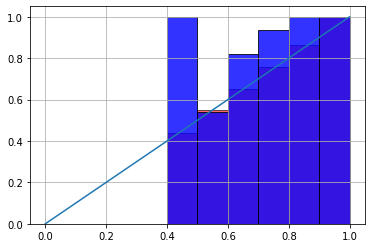

In [9]:
plt.plot(np.linspace(0,1,11), np.linspace(0,1,11))
plt.bar(x_axis, conf_list,  width=0.1, edgecolor="black", align='edge', alpha=0.6, color='red')
plt.bar(x_axis, acc_list,  width=0.1, edgecolor="black", alpha=0.8, align='edge', color='blue')
plt.grid()
ECE = np.sum(np.abs((np.array(acc_list)-np.array(conf_list))) * counts) / 10000
print(ECE)
plt.savefig('train_none_conf_{:.4f}.pdf'.format(ECE))

In [18]:
label_list, out_list, pred_list, score_list, logit_sum_list = get_statistics(dataloaders, device, representer, teacher, mode = 'test')
x_axis, conf_list, acc_list, counts = compute_reliability_diagram(label_list, pred_list, score_list)

[0.000e+00 0.000e+00 0.000e+00 7.000e+00 2.100e+01 8.500e+01 1.320e+02
 1.530e+02 2.490e+02 8.246e+03]
[0.00000000e+00 0.00000000e+00 2.99019068e-01 6.49383739e+00
 2.85935177e+01 1.22947779e+02 1.69009545e+02 2.14030569e+02
 3.41369753e+02 8.70150178e+03]


0.06922581210732451


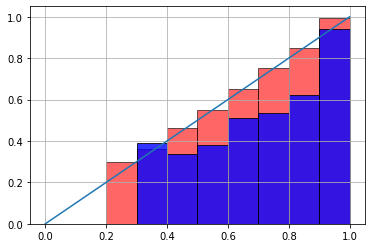

In [19]:
plt.plot(np.linspace(0,1,11), np.linspace(0,1,11))
plt.bar(x_axis, conf_list,  width=0.1, edgecolor="black", align='edge', alpha=0.6, color='red')
plt.bar(x_axis, acc_list,  width=0.1, edgecolor="black", alpha=0.8, align='edge', color='blue')
plt.grid()
ECE = np.sum(np.abs((np.array(acc_list)-np.array(conf_list))) * counts) / 10000
print(ECE)
plt.savefig('test_none_conf_{:.4f}.pdf'.format(ECE))

----

# norm

In [22]:
device = 'cuda:0'

# teacher = ResNet(opt = 'none', init = 'kaiming', num_classes = 10, batchnorm = True, width = 4, depth = 50, bottleneck= True)
teacher = ResNet(opt = 'none', init = 'kaiming', num_classes = 10, batchnorm = True, width = 4, depth = 50, bottleneck= False)

# filename = './checkpoint/cifar10/res-50-4-t-bn/sgd/step/kaiming_both_none_0.1_0.1_0.1_0.1_seed1_False.pt'
# filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/ort_both_none_0.01_0.01_0.01_0.01_seed3.pt'
filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/ort_both_norm_0.1_0.1_0.1_0.1_seed1_True.pt'
# filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/xavier_both_srip_0.1_0.1_0.1_0.1_seed1.pt'

# filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/ort_both_ortho_0.01_0.01_0.01_0.01_seed4_True.pt' # ortho
# filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/xavier_both_ort_0.1_0.1_0.1_0.1_seed1_True.pt' #norm

checkpoint = torch.load(filename, map_location=device)['best_wts']
teacher.load_state_dict(checkpoint, strict=False)
teacher.eval()
teacher = teacher.to(device)
representer = Represent(teacher)

In [23]:
label_list, out_list, pred_list, score_list, logit_sum_list = get_statistics(dataloaders, device, representer, teacher, mode = 'train')
x_axis, conf_list, acc_list, counts = compute_reliability_diagram(label_list, pred_list, score_list)

[0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 6.0000e+00 2.0000e+01
 3.5000e+01 3.6000e+01 7.7000e+01 4.9546e+04]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.87995544e+00
 5.87244672e+00 2.75964152e+01 3.66019262e+01 5.21291873e+01
 9.46197802e+01 4.96727663e+04]


0.017072113099694555


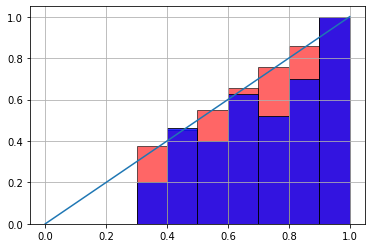

In [24]:
plt.plot(np.linspace(0,1,11), np.linspace(0,1,11))
plt.bar(x_axis, conf_list,  width=0.1, edgecolor="black", align='edge', alpha=0.6, color='red')
plt.bar(x_axis, acc_list,  width=0.1, edgecolor="black", alpha=0.8, align='edge', color='blue')
plt.grid()
ECE = np.sum(np.abs((np.array(acc_list)-np.array(conf_list))) * counts) / 10000
print(ECE)
plt.savefig('train_norm_conf_{:.4f}.pdf'.format(ECE))

In [25]:
label_list, out_list, pred_list, score_list, logit_sum_list = get_statistics(dataloaders, device, representer, teacher, mode = 'test')
x_axis, conf_list, acc_list, counts = compute_reliability_diagram(label_list, pred_list, score_list)

[0.000e+00 0.000e+00 0.000e+00 1.000e+00 8.000e+00 5.000e+01 5.100e+01
 7.500e+01 1.010e+02 9.155e+03]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 2.19186118e+00
 1.12417047e+01 5.97806259e+01 6.62099663e+01 9.54126441e+01
 1.37646432e+02 9.44658233e+03]


0.03780655645430086


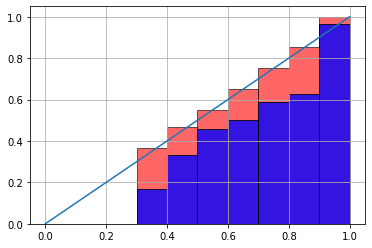

In [26]:
plt.plot(np.linspace(0,1,11), np.linspace(0,1,11))
plt.bar(x_axis, conf_list,  width=0.1, edgecolor="black", align='edge', alpha=0.6, color='red')
plt.bar(x_axis, acc_list,  width=0.1, edgecolor="black", alpha=0.8, align='edge', color='blue')
plt.grid()
ECE = np.sum(np.abs((np.array(acc_list)-np.array(conf_list))) * counts) / 10000
print(ECE)
plt.savefig('test_norm_conf_{:.4f}.pdf'.format(ECE))

-----

# SRIP

In [27]:
device = 'cuda:1'

# teacher = ResNet(opt = 'none', init = 'kaiming', num_classes = 10, batchnorm = True, width = 4, depth = 50, bottleneck= True)
teacher = ResNet(opt = 'none', init = 'kaiming', num_classes = 10, batchnorm = True, width = 4, depth = 50, bottleneck= False)

# filename = './checkpoint/cifar10/res-50-4-t-bn/sgd/step/kaiming_both_none_0.1_0.1_0.1_0.1_seed1_False.pt'
# filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/ort_both_none_0.01_0.01_0.01_0.01_seed3.pt'
filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/kaiming_both_srip_0.1_0.1_0.1_0.1_seed1.pt'
# filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/xavier_both_srip_0.1_0.1_0.1_0.1_seed1.pt'

# filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/ort_both_ortho_0.01_0.01_0.01_0.01_seed4_True.pt' # ortho
# filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/xavier_both_ort_0.1_0.1_0.1_0.1_seed1_True.pt' #norm

checkpoint = torch.load(filename, map_location=device)['best_wts']
teacher.load_state_dict(checkpoint, strict=False)
teacher.eval()
teacher = teacher.to(device)
representer = Represent(teacher)

In [28]:
label_list, out_list, pred_list, score_list, logit_sum_list = get_statistics(dataloaders, device, representer, teacher, mode = 'test')
x_axis, conf_list, acc_list,counts = compute_reliability_diagram(label_list, pred_list, score_list)

[0.000e+00 0.000e+00 0.000e+00 4.000e+00 1.200e+01 5.900e+01 7.000e+01
 7.400e+01 1.660e+02 9.028e+03]
[0.00000000e+00 0.00000000e+00 5.51290244e-01 3.69386551e+00
 1.55617069e+01 7.10470047e+01 8.58852592e+01 1.19168426e+02
 2.02805403e+02 9.26365547e+03]


0.034998068943619814


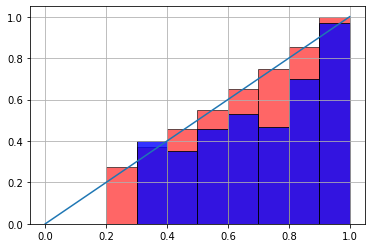

In [29]:
plt.plot(np.linspace(0,1,11), np.linspace(0,1,11))
plt.bar(x_axis, conf_list,  width=0.1, edgecolor="black", align='edge', alpha=0.6, color='red')
plt.bar(x_axis, acc_list,  width=0.1, edgecolor="black", alpha=0.8, align='edge', color='blue')
plt.grid()
ECE = np.sum(np.abs((np.array(acc_list)-np.array(conf_list))) * counts) / 10000
print(ECE)
plt.savefig('test_srip_conf_{:.4f}.pdf'.format(ECE))

---

# tem 20

In [30]:
device = 'cuda:1'

# teacher = ResNet(opt = 'none', init = 'kaiming', num_classes = 10, batchnorm = True, width = 4, depth = 50, bottleneck= True)
teacher = ResNet(opt = 'none', init = 'kaiming', num_classes = 10, batchnorm = True, width = 4, depth = 50, bottleneck= False)

# filename = './checkpoint/cifar10/res-50-4-t-bn/sgd/step/kaiming_both_none_0.1_0.1_0.1_0.1_seed1_False.pt'
# filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/ort_both_none_0.01_0.01_0.01_0.01_seed3.pt'
filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/xavier_both_srip_0.1_0.1_0.1_0.1_seed1.pt'
# filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/xavier_both_srip_0.1_0.1_0.1_0.1_seed1.pt'

# filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/ort_both_ortho_0.01_0.01_0.01_0.01_seed4_True.pt' # ortho
# filename = './checkpoint/cifar10/res-50-4-f-bn/sgd/step/xavier_both_ort_0.1_0.1_0.1_0.1_seed1_True.pt' #norm

checkpoint = torch.load(filename, map_location=device)['best_wts']
teacher.load_state_dict(checkpoint, strict=False)
teacher.eval()
teacher = teacher.to(device)
representer = Represent(teacher)

In [31]:
label_list, out_list, pred_list, score_list, logit_sum_list = get_statistics(dataloaders, device, representer, teacher, mode = 'test')
x_axis, conf_list, acc_list,counts = compute_reliability_diagram(label_list, pred_list, score_list)

[0.000e+00 0.000e+00 0.000e+00 2.000e+00 1.300e+01 6.300e+01 6.900e+01
 7.200e+01 1.410e+02 9.059e+03]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 4.40488476e+00
 1.65809584e+01 7.63835248e+01 7.29429224e+01 1.07612308e+02
 1.73595890e+02 9.32277765e+03]


0.03552981413602829


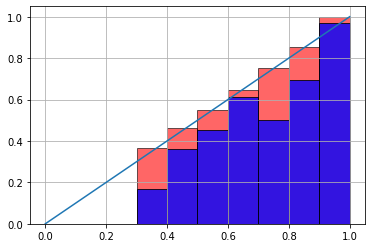

In [32]:
plt.plot(np.linspace(0,1,11), np.linspace(0,1,11))
plt.bar(x_axis, conf_list,  width=0.1, edgecolor="black", align='edge', alpha=0.6, color='red')
plt.bar(x_axis, acc_list,  width=0.1, edgecolor="black", alpha=0.8, align='edge', color='blue')
plt.grid()
ECE = np.sum(np.abs((np.array(acc_list)-np.array(conf_list))) * counts) / 10000
print(ECE)
plt.savefig('test_srip_p_conf_{:.4f}.pdf'.format(ECE))

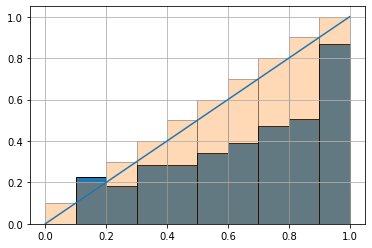

In [181]:
plt.plot(np.linspace(0,1,11), np.linspace(0,1,11))
plt.bar(x_axis, acc_list,  width=0.1, edgecolor="black", align='edge')
plt.bar(x_axis, x_axis+0.1,  width=0.1, edgecolor="black", alpha=0.3, align='edge')
plt.grid()
plt.savefig('acc_tem20_conf_{:.3f}.pdf'.format(np.sum(np.linspace(0.1, 1.0, 10)-acc_list)))

---

# tem 100

In [288]:
device = torch.device('cuda:0')

teacher = cifar.WideResNet(depth=16, widen_factor=2, num_classes=100)
# filename = './model_checkpoints/cifar100/None/wrn-28-4/alp_0.1_T_1.0/random_highest_1.0_random_highest_1.0_seed9999_none.t1'
# filename = './model_checkpoints/cifar100/None/wrn-16-2/alp_0.1_T_1.0/random_highest_1.0_random_highest_1.0_seed9999_none.t1'
# filename = './model_checkpoints/cifar100/wrn-28-4/wrn-16-2/alp_1.0_T_3.0/random_0.0-1.0_random_0.0-1.0_seed9999_none_noclas.t1'
# filename = './model_checkpoints/cifar100/wrn-28-4/wrn-16-2/alp_1.0_T_20.0/random_0.0-1.0_random_0.0-1.0_seed9999_none_noclas.t1'
filename = './model_checkpoints/cifar100/wrn-28-4/wrn-16-2/alp_1.0_T_100.0/random_0.0-1.0_random_0.0-1.0_seed9999_none_noclas.t1'
# filename = './model_checkpoints/cifar100/wrn-28-4/wrn-16-2/alp_1.0_T_150.0/random_0.0-1.0_random_0.0-1.0_seed9999_none_noclas.t1'
# filename = './model_checkpoints/cifar100/wrn-28-4/wrn-16-2/alp_1.0_T_1000.0/random_0.0-1.0_random_0.0-1.0_seed9999_none_noclas.t1'

# filename = './model_checkpoints/cifar100/wrn-28-4/wrn-16-2/alp_0.0_T_0.0/random_highest_1.0_random_highest_1.0_seed9999.t1'
checkpoint = torch.load(filename, map_location=device)['199']
teacher.load_state_dict(checkpoint, strict=True)
teacher.eval()
device = 'cuda:0'
teacher = teacher.to(device)
representer = Represent(teacher)

In [289]:
label_list, out_list, pred_list, score_list, logit_sum_list = get_statistics(dataloaders, device, representer, teacher, mode = 'test')
x_axis, conf_list, acc_list, counts = compute_reliability_diagram(label_list, pred_list, score_list)

[0.000e+00 5.000e+00 1.500e+01 3.900e+01 1.020e+02 1.720e+02 1.540e+02
 2.060e+02 3.600e+02 6.388e+03]
[2.77909629e-01 4.74192138e+00 2.45644889e+01 7.00022464e+01
 1.44564872e+02 2.55019252e+02 2.78881925e+02 3.37528005e+02
 5.80315688e+02 7.26436443e+03]


0.15197769008651377


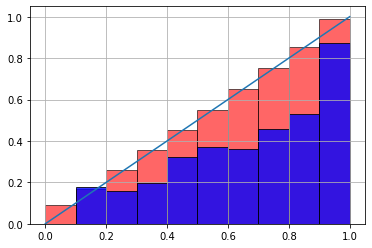

In [291]:
plt.plot(np.linspace(0,1,11), np.linspace(0,1,11))
plt.bar(x_axis, conf_list,  width=0.1, edgecolor="black", align='edge', alpha=0.6, color='red')
plt.bar(x_axis, acc_list,  width=0.1, edgecolor="black", alpha=0.8, align='edge', color='blue')
plt.grid()
ECE = np.sum(np.abs((np.array(acc_list)-np.array(conf_list))) * counts) / 10000
print(ECE)
plt.savefig('ece_tem100_conf_{:.4f}.pdf'.format(ECE))

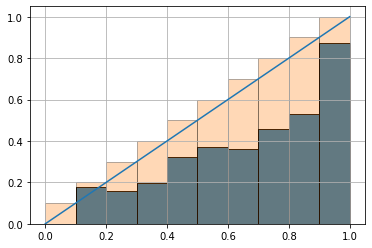

In [186]:
plt.plot(np.linspace(0,1,11), np.linspace(0,1,11))
plt.bar(x_axis, acc_list,  width=0.1, edgecolor="black", align='edge')
plt.bar(x_axis, x_axis+0.1,  width=0.1, edgecolor="black", alpha=0.3, align='edge')
plt.grid()
plt.savefig('acc_tem100_conf_{:.3f}.pdf'.format(np.sum(np.linspace(0.1, 1.0, 10)-acc_list)))

---

# tem 150

In [292]:
device = torch.device('cuda:0')

teacher = cifar.WideResNet(depth=16, widen_factor=2, num_classes=100)
# filename = './model_checkpoints/cifar100/None/wrn-28-4/alp_0.1_T_1.0/random_highest_1.0_random_highest_1.0_seed9999_none.t1'
# filename = './model_checkpoints/cifar100/None/wrn-16-2/alp_0.1_T_1.0/random_highest_1.0_random_highest_1.0_seed9999_none.t1'
# filename = './model_checkpoints/cifar100/wrn-28-4/wrn-16-2/alp_1.0_T_3.0/random_0.0-1.0_random_0.0-1.0_seed9999_none_noclas.t1'
# filename = './model_checkpoints/cifar100/wrn-28-4/wrn-16-2/alp_1.0_T_20.0/random_0.0-1.0_random_0.0-1.0_seed9999_none_noclas.t1'
# filename = './model_checkpoints/cifar100/wrn-28-4/wrn-16-2/alp_1.0_T_100.0/random_0.0-1.0_random_0.0-1.0_seed9999_none_noclas.t1'
filename = './model_checkpoints/cifar100/wrn-28-4/wrn-16-2/alp_1.0_T_150.0/random_0.0-1.0_random_0.0-1.0_seed9999_none_noclas.t1'
# filename = './model_checkpoints/cifar100/wrn-28-4/wrn-16-2/alp_1.0_T_1000.0/random_0.0-1.0_random_0.0-1.0_seed9999_none_noclas.t1'

# filename = './model_checkpoints/cifar100/wrn-28-4/wrn-16-2/alp_0.0_T_0.0/random_highest_1.0_random_highest_1.0_seed9999.t1'
checkpoint = torch.load(filename, map_location=device)['199']
teacher.load_state_dict(checkpoint, strict=True)
teacher.eval()
device = 'cuda:0'
teacher = teacher.to(device)
representer = Represent(teacher)

In [293]:
label_list, out_list, pred_list, score_list, logit_sum_list = get_statistics(dataloaders, device, representer, teacher, mode = 'test')
x_axis, conf_list, acc_list, counts = compute_reliability_diagram(label_list, pred_list, score_list)

[0.00e+00 3.00e+00 1.90e+01 5.40e+01 8.80e+01 1.54e+02 1.94e+02 2.09e+02
 3.54e+02 6.43e+03]
[0.00000000e+00 4.34340854e+00 2.94431923e+01 7.65168610e+01
 1.38180871e+02 2.35344734e+02 3.16841408e+02 3.35625318e+02
 5.54510668e+02 7.25190736e+03]


0.1437713823720813


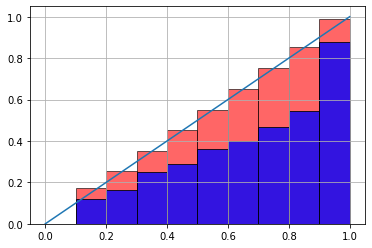

In [295]:
plt.plot(np.linspace(0,1,11), np.linspace(0,1,11))
plt.bar(x_axis, conf_list,  width=0.1, edgecolor="black", align='edge', alpha=0.6, color='red')
plt.bar(x_axis, acc_list,  width=0.1, edgecolor="black", alpha=0.8, align='edge', color='blue')
plt.grid()
ECE = np.sum(np.abs((np.array(acc_list)-np.array(conf_list))) * counts) / 10000
print(ECE)
plt.savefig('ece_inf_conf_{:.4f}.pdf'.format(ECE))

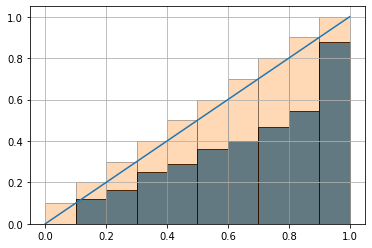

In [196]:
plt.plot(np.linspace(0,1,11), np.linspace(0,1,11))
plt.bar(x_axis, acc_list,  width=0.1, edgecolor="black", align='edge')
plt.bar(x_axis, x_axis+0.1,  width=0.1, edgecolor="black", alpha=0.3, align='edge')
plt.grid()
plt.savefig('acc_tem150_conf_{:.3f}.pdf'.format(np.sum(np.linspace(0.1, 1.0, 10)-acc_list)))

---

# tem 1000

In [296]:
device = torch.device('cuda:0')

teacher = cifar.WideResNet(depth=16, widen_factor=2, num_classes=100)
# filename = './model_checkpoints/cifar100/None/wrn-28-4/alp_0.1_T_1.0/random_highest_1.0_random_highest_1.0_seed9999_none.t1'
# filename = './model_checkpoints/cifar100/None/wrn-16-2/alp_0.1_T_1.0/random_highest_1.0_random_highest_1.0_seed9999_none.t1'
# filename = './model_checkpoints/cifar100/wrn-28-4/wrn-16-2/alp_1.0_T_3.0/random_0.0-1.0_random_0.0-1.0_seed9999_none_noclas.t1'
# filename = './model_checkpoints/cifar100/wrn-28-4/wrn-16-2/alp_1.0_T_20.0/random_0.0-1.0_random_0.0-1.0_seed9999_none_noclas.t1'
# filename = './model_checkpoints/cifar100/wrn-28-4/wrn-16-2/alp_1.0_T_100.0/random_0.0-1.0_random_0.0-1.0_seed9999_none_noclas.t1'
# filename = './model_checkpoints/cifar100/wrn-28-4/wrn-16-2/alp_1.0_T_150.0/random_0.0-1.0_random_0.0-1.0_seed9999_none_noclas.t1'
filename = './model_checkpoints/cifar100/wrn-28-4/wrn-16-2/alp_1.0_T_1000.0/random_0.0-1.0_random_0.0-1.0_seed9999_none_noclas.t1'

# filename = './model_checkpoints/cifar100/wrn-28-4/wrn-16-2/alp_0.0_T_0.0/random_highest_1.0_random_highest_1.0_seed9999.t1'
checkpoint = torch.load(filename, map_location=device)['199']
teacher.load_state_dict(checkpoint, strict=True)
teacher.eval()
device = 'cuda:0'
teacher = teacher.to(device)
representer = Represent(teacher)

In [297]:
label_list, out_list, pred_list, score_list, logit_sum_list = get_statistics(dataloaders, device, representer, teacher, mode = 'test')
x_axis, conf_list, acc_list,counts = compute_reliability_diagram(label_list, pred_list, score_list)

[0.000e+00 5.000e+00 2.200e+01 5.000e+01 9.300e+01 1.660e+02 1.840e+02
 2.310e+02 3.530e+02 6.413e+03]
[0.00000000e+00 5.30490091e+00 2.78472640e+01 7.57421328e+01
 1.40703921e+02 2.50831814e+02 2.85803441e+02 3.71093033e+02
 5.65598747e+02 7.21215930e+03]


0.1418084557428956


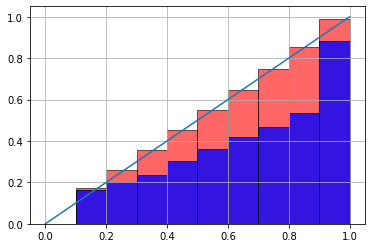

In [299]:
plt.plot(np.linspace(0,1,11), np.linspace(0,1,11))
plt.bar(x_axis, conf_list,  width=0.1, edgecolor="black", align='edge', alpha=0.6, color='red')
plt.bar(x_axis, acc_list,  width=0.1, edgecolor="black", alpha=0.8, align='edge', color='blue')
plt.grid()
ECE = np.sum(np.abs((np.array(acc_list)-np.array(conf_list))) * counts) / 10000
print(ECE)
plt.savefig('ece_tem1000_conf_{:.4f}.pdf'.format(ECE))

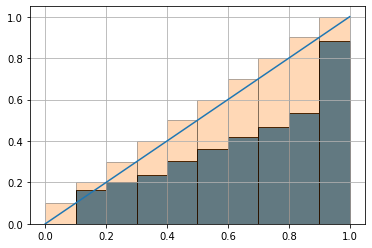

In [200]:
plt.plot(np.linspace(0,1,11), np.linspace(0,1,11))
plt.bar(x_axis, acc_list,  width=0.1, edgecolor="black", align='edge')
plt.bar(x_axis, x_axis+0.1,  width=0.1, edgecolor="black", alpha=0.3, align='edge')
plt.grid()
plt.savefig('acc_tem1000_conf_{:.3f}.pdf'.format(np.sum(np.linspace(0.1, 1.0, 10)-acc_list)))

---

# mse

In [300]:
device = torch.device('cuda:0')

teacher = cifar.WideResNet(depth=16, widen_factor=2, num_classes=100)
# filename = './model_checkpoints/cifar100/None/wrn-28-4/alp_0.1_T_1.0/random_highest_1.0_random_highest_1.0_seed9999_none.t1'
# filename = './model_checkpoints/cifar100/None/wrn-16-2/alp_0.1_T_1.0/random_highest_1.0_random_highest_1.0_seed9999_none.t1'
# filename = './model_checkpoints/cifar100/wrn-28-4/wrn-16-2/alp_1.0_T_3.0/random_0.0-1.0_random_0.0-1.0_seed9999_none_noclas.t1'
# filename = './model_checkpoints/cifar100/wrn-28-4/wrn-16-2/alp_1.0_T_20.0/random_0.0-1.0_random_0.0-1.0_seed9999_none_noclas.t1'
# filename = './model_checkpoints/cifar100/wrn-28-4/wrn-16-2/alp_1.0_T_100.0/random_0.0-1.0_random_0.0-1.0_seed9999_none_noclas.t1'
# filename = './model_checkpoints/cifar100/wrn-28-4/wrn-16-2/alp_1.0_T_150.0/random_0.0-1.0_random_0.0-1.0_seed9999_none_noclas.t1'
# filename = './model_checkpoints/cifar100/wrn-28-4/wrn-16-2/alp_1.0_T_1000.0/random_0.0-1.0_random_0.0-1.0_seed9999_none_noclas.t1'
# filename = './model_checkpoints/cifar100/wrn-28-4/wrn-16-2/alp_1.0_T_1.0/random_0.0-1.0_random_0.0-1.0_seed9999_l2_logit_noclas.t1'
filename = './model_checkpoints/cifar100/wrn-28-4/wrn-16-2/alp_0.0_T_0.0/random_highest_1.0_random_highest_1.0_seed9999.t1'
checkpoint = torch.load(filename, map_location=device)['199']
teacher.load_state_dict(checkpoint, strict=True)
teacher.eval()
device = 'cuda:0'
teacher = teacher.to(device)
representer = Represent(teacher)

In [301]:
label_list, out_list, pred_list, score_list, logit_sum_list = get_statistics(dataloaders, device, representer, teacher, mode = 'test')
x_axis, conf_list, acc_list, counts = compute_reliability_diagram(label_list, pred_list, score_list)

[1.000e+00 1.700e+01 5.800e+01 9.000e+01 1.500e+02 1.870e+02 2.220e+02
 2.910e+02 4.740e+02 6.009e+03]
[1.02072643e+00 2.01337137e+01 6.24954742e+01 1.19679012e+02
 1.84206984e+02 2.62257075e+02 3.23669426e+02 4.02424722e+02
 6.27825982e+02 6.54117042e+03]


0.10458835309557614


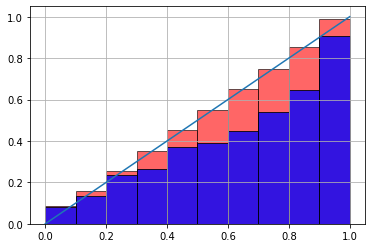

In [303]:
plt.plot(np.linspace(0,1,11), np.linspace(0,1,11))
plt.bar(x_axis, conf_list,  width=0.1, edgecolor="black", align='edge', alpha=0.6, color='red')
plt.bar(x_axis, acc_list,  width=0.1, edgecolor="black", alpha=0.8, align='edge', color='blue')
plt.grid()
ECE = np.sum(np.abs((np.array(acc_list)-np.array(conf_list))) * counts) / 10000
print(ECE)
plt.savefig('ece_mse_conf_{:.4f}.pdf'.format(ECE))

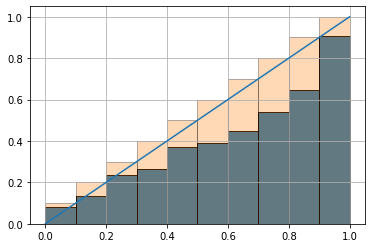

In [204]:
plt.plot(np.linspace(0,1,11), np.linspace(0,1,11))
plt.bar(x_axis, acc_list,  width=0.1, edgecolor="black", align='edge')
plt.bar(x_axis, x_axis+0.1,  width=0.1, edgecolor="black", alpha=0.3, align='edge')
plt.grid()
plt.savefig('acc_mse_conf_{:.3f}.pdf'.format(np.sum(np.linspace(0.1, 1.0, 10)-acc_list)))

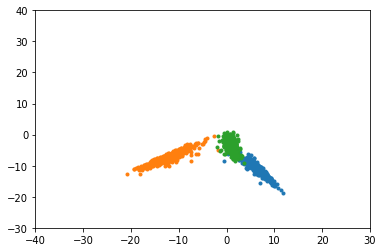

In [156]:
label_list, out_list, pred_list, score_list, logit_sum_list = get_statistics(dataloaders, device, representer, teacher, mode = 'train')
v_ortho_dict = teacher.linear.weight
out, sing_lbl = get_plane(v_ortho_dict, out_list, label_list, device, mode = 'inter')
a, b = make_orthonormal_basis(out)
x, y = projection(out, a, b)

candidate = [0, 1, 2]
for j in candidate:
    plt.plot(x[label_list[sing_lbl]==j],y[label_list[sing_lbl]==j],'.')
plt.xlim(-40,30)
plt.ylim(-30,40)
plt.savefig('mse_train_inter.pdf')

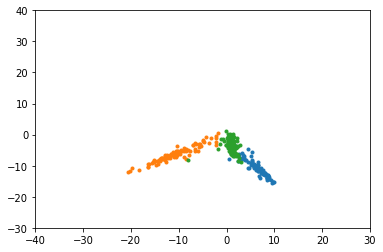

In [157]:
label_list, out_list, pred_list, score_list, logit_sum_list = get_statistics(dataloaders, device, representer, teacher, mode = 'test')
v_ortho_dict = teacher.linear.weight
out, sing_lbl = get_plane(v_ortho_dict, out_list, label_list, device, mode = 'inter')
x, y = projection(out, a, b)

candidate = [0, 1, 2]
for j in candidate:
    plt.plot(x[label_list[sing_lbl]==j],y[label_list[sing_lbl]==j],'.')
plt.xlim(-40,30)
plt.ylim(-30,40)
plt.savefig('mse_test_inter.pdf')